In [62]:
!pip freeze | grep tensorflow==2.6

'grep' is not recognized as an internal or external command,
operable program or batch file.


In [17]:
from __future__ import print_function
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [19]:
#Let's install Altair for interactive visualizations
# !pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [21]:
# Load each data set (users, ratings, and movies).
users = pd.read_csv('777user.csv', encoding='latin-1')

ratings = pd.read_csv('rating_777user.csv', encoding='latin-1')


genre_cols = [
    'Action', 'Adventure', 'Comedy', 'Contemporary Romance', 'Drama', 'Eastern Fantasy',
    'Ecchi', 'Fantasy', 'Fantasy Romance', 'Gender Bender', 'Harem', 'Historical',
    'Horror', 'Josei', 'Lolicon', 'Magical Realism', 'Martial Arts', 'Mecha', 'Mystery',
    'Psychological', 'Romance', 'School Life', 'Sci-fi', 'Seinen', 'Shoujo', 'Shounen',
    'Shounen Ai', 'Slice of Life', 'Smut', 'Sports', 'Supernatural', 'Tragedy', 'Video Games',
    'Wuxia', 'Xianxia', 'Xuanhuan', 'Yaoi', 'Fan-Fiction', 'Urban', 'Virtual Reality', 'Faloo', 'Korean'
    ]


novels = pd.read_csv('clean_categories_matrix.csv',encoding='utf-8')
# Since the ids start at 1, we shift them to start at 0. This will make handling of the
# indices easier later
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))

novels["novel_id"] = novels["novel_id"].apply(lambda x: str(x))
novels["chapters"] = novels["chapters"].apply(lambda x: str(x))
novels["status"] = novels["status"].apply(lambda x: str(x))

ratings["novel_id"] = ratings["novel_id"].apply(lambda x: str(x))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
novels = novels.drop(columns=['author'])

In [46]:
novels.shape

(28116, 48)

In [23]:
# Compute the number of movies to which a genre is assigned.
genre_occurences = novels[genre_cols].sum().to_dict()

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(novels, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  novels['genre'] = [
      get_random_genre(gs) for gs in zip(*[novels[genre] for genre in genres])]
  novels['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[novels[genre] for genre in genres])]

mark_genres(novels, genre_cols)

# Create one merged DataFrame containing all the movielens data.
novellens = ratings.merge(novels, on='novel_id').merge(users, on='user_id')

In [24]:
novellens.head()

,user_id,novel_id,rating,title,chapters,status,Action,Adventure,Comedy,Contemporary Romance,...,Yaoi,Fan-Fiction,Urban,Virtual Reality,Faloo,Korean,genre,all_genres,sex,age
0,505,308,10.000,The Female Partner Refuses To Be Cannon Fodder,3085,0.8571428571428571,0,0,0,0,...,0,0,0,0,0,0,Romance,Romance,0,25
1,505,27466,5.000,Mozun is Running Away From Marriage Every Day,No,0.1428571428571428,0,0,0,0,...,0,0,0,0,0,0,Xianxia,Shounen Ai-Xianxia,0,25
2,505,21360,9.000,People in Ke Xue: The beginning of living with...,088,0.8571428571428571,0,0,0,0,...,0,1,0,0,1,0,Fan-Fiction,Fan-Fiction-Faloo,0,25
3,505,1911,3.000,Villain: Heroine Sacrifice To Heaven At The Start,541,0.8571428571428571,0,0,0,0,...,0,0,1,0,0,0,Urban,Urban,0,25
4,505,2349,5.000,Myriad Realms Store Owner of Harry Potter,752,0.1428571428571428,1,1,0,0,...,0,0,0,0,0,0,Action,Action-Adventure-Fantasy-Xuanhuan,0,25


In [25]:
# Utility to split the data into training and test sets.

def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [26]:
ratings

,user_id,novel_id,rating
0,505,308,10.000
1,72,1719,4.000
2,522,5143,3.000
3,560,15075,7.000
4,191,20499,7.000
...,...,...,...
98556,650,4539,7.000
98557,649,8815,5.000
98558,653,4940,3.000
98559,125,15119,10.000


In [27]:
novels_ratings = novels.merge(
    ratings
    .groupby('novel_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='novel_id')

genre_filter = alt.selection_point(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

In [82]:
full_rate_id = ratings['novel_id'].unique()

novel_lens, d = novels.shape
numbers = range(1, novel_lens)

missing_numbers = [num for num in numbers if str(num) not in full_rate_id]
if missing_numbers:
    print("Numbers from 1 to 30000 not present in distinct_novel_ids:")
    print(missing_numbers)
else:
    print("All numbers from 1 to 30000 are present in distinct_novel_ids.")

Numbers from 1 to 30000 not present in distinct_novel_ids:
[20, 27, 44, 91, 126, 140, 141, 148, 168, 174, 241, 242, 266, 304, 313, 327, 341, 413, 429, 456, 459, 478, 482, 511, 560, 563, 589, 602, 609, 612, 620, 629, 667, 692, 694, 772, 806, 828, 872, 931, 979, 984, 1009, 1010, 1015, 1037, 1060, 1074, 1092, 1097, 1099, 1118, 1241, 1255, 1290, 1346, 1376, 1379, 1385, 1388, 1428, 1431, 1473, 1510, 1513, 1534, 1587, 1611, 1626, 1630, 1654, 1692, 1700, 1785, 1842, 1849, 1962, 1965, 2077, 2090, 2185, 2271, 2295, 2313, 2322, 2361, 2391, 2433, 2442, 2465, 2501, 2540, 2580, 2586, 2592, 2633, 2698, 2722, 2731, 2749, 2767, 2848, 2950, 3020, 3039, 3076, 3077, 3097, 3160, 3162, 3165, 3217, 3236, 3343, 3360, 3371, 3408, 3442, 3475, 3533, 3578, 3695, 3705, 3736, 3758, 3763, 3797, 3902, 3924, 3990, 4013, 4018, 4040, 4198, 4247, 4296, 4321, 4327, 4376, 4410, 4471, 4538, 4563, 4695, 4710, 4800, 4803, 4807, 4834, 4846, 4849, 4852, 4899, 4919, 4970, 4973, 5024, 5205, 5209, 5216, 5256, 5261, 5273, 5287, 53

In [77]:
type(missing_numbers)

list

In [29]:
(novels_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x > 10)
 .sort_values('rating mean', ascending=False)
 .head(10))

,title,rating count,rating mean
22753,Genshin Impact: I’m live streaming in Teyvat,11,8.364
6288,Tattoo Awakening: All Kinds of Divine Beasts C...,11,8.000
19447,"Daqin: Incarnation without misery, summoning t...",11,8.000
17975,Tomb Raiders: the Red Girl at the Beginning Be...,12,8.000
26643,Entertainment: I am playing a hidden marriage ...,13,7.846
7673,Rebirth: from Supermarket to Perfectly Rich,12,7.750
14936,"Mysterious Young Master, Super Cool",11,7.727
20210,"Dead contract: Sign in for ten years, and you ...",11,7.727
7217,Hogwarts Please graduate soon,11,7.727
23752,Crispy college student? The whole internet exc...,12,7.500


In [30]:
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_id', 'novel_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], novels.shape[0]])

In [31]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, novel_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, novel_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [32]:
#Alternative Solution
def sparse_mean_square_error(sparse_ratings, user_embeddings, novel_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(novel_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss



In [33]:

class CFModel(object):
  def __init__(self, embedding_vars, loss, metrics=None):
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.compat.v1.train.GradientDescentOptimizer):
    
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          #tf.train.start_queue_runners()

    with self._session.as_default():

      local_init_op.run()

      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):

        _, results = self._session.run((train_op, metrics))

        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [34]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random.normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "novel_id": V
  }

  return CFModel(embeddings, train_loss, [metrics])

In [35]:

model = build_model(novellens, embedding_dim=30, init_stddev=0.5)

 iteration 180: train_error=2.190535, test_error=65.6050261

 iteration 1000: train_error=0.011721, test_error=67.461098

[{'train_error': 0.011720629, 'test_error': 67.4611}]

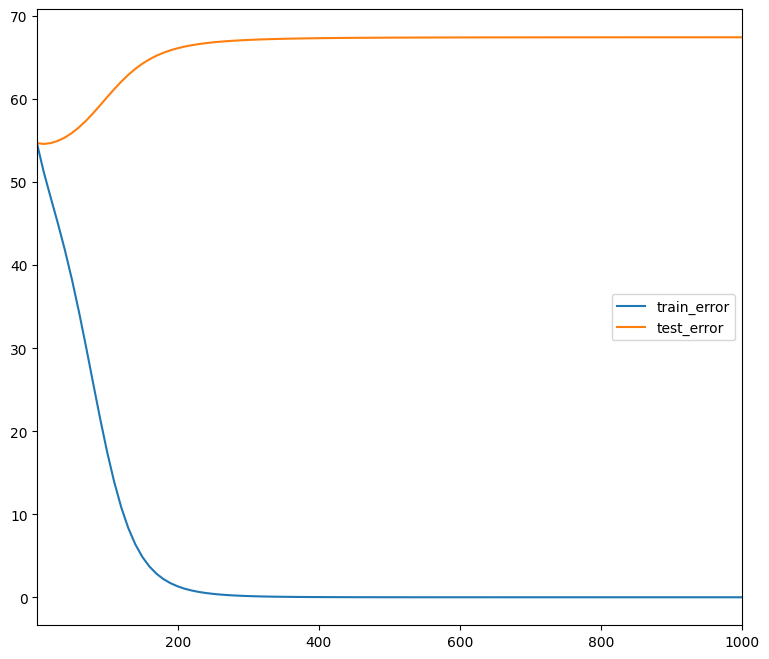

In [36]:
model.train(num_iterations=1000, learning_rate=10.)

In [37]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [109]:

def user_recommendations(model, user_id, measure=DOT, exclude_rated=False, k=6, USER_RATINGS= None):
  
  scores = compute_scores(model.embeddings["user_id"][user_id], model.embeddings["novel_id"], measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      'novel_id': novels['novel_id'],
      score_key: list(scores),
      'titles': novels['title'],
      'genres': novels['all_genres']
  })
  if exclude_rated:
    # remove movies that are already rated
    rated_novels = ratings[ratings.user_id == user_id]["novel_id"].values
    df = df[df.novel_id.apply(lambda novel_id: novel_id not in rated_novels)]
  display.display(df.sort_values([score_key], ascending=False).head(k))  

def novel_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  novels[novels['title'].str.contains(title_substring)].index.values
  titles = novels.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no novel with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching nove. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  novel_id = ids[0]
  scores = compute_scores(
      model.embeddings["novel_id"][novel_id], model.embeddings["novel_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      'novel_id': novels['novel_id'],
      score_key: list(scores),
      'titles': novels['title'],
      'genres': novels['all_genres']
  })
  tf = df.loc[df['novel_id'] == '9']
  print(tf)
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [110]:
novel_neighbors(model, "Madam’s Identities Shocks the Entire City Again", DOT, 20)



Nearest neighbors of : Madam’s Identities Shocks the Entire City Again.
  novel_id  dot score                  titles            genres
8        9      1.878  Permanent Martial Arts  Fantasy-Xuanhuan


,novel_id,dot score,titles,genres
0,1,7.693,Madam’s Identities Shocks the Entire City Again,Drama-Romance
21569,21570,5.548,"In the apocalypse of the book, the ship girl a...",Fan-Fiction
13439,13440,5.487,Fantasy: Start with three thousand holy realms...,Fantasy Romance
19356,19357,5.469,"A man wrote a biography while sailing, which s...",Fan-Fiction-Faloo
21031,21032,5.297,Taking stock of the ten major catastrophes for...,Fan-Fiction-Faloo
...,...,...,...,...
16392,16393,4.876,"Navigation: Kizaru, my brother, becomes strong...",Fan-Fiction-Faloo
4184,4185,4.869,A Simulation Game of the Heavens Starting From...,Fan-Fiction
17386,17387,4.820,Three Kingdoms: Eight hundred snow dragons rid...,Fan-Fiction
3802,3803,4.811,Rebirth Of A Noble Daughter: The Marquis Manor...,Historical-Josei-Psychological-Romance


##***Softmax model***


In [40]:
rated_novels = (ratings[["user_id", "novel_id"]]
                .groupby("user_id", as_index=False)
                .aggregate(lambda x: list(x)))
rated_novels.head()

,user_id,novel_id
0,0,"[15516, 5559, 8324, 7738, 20068, 27068, 19251,..."
1,1,"[12569, 556, 22718, 18969, 24018, 18336, 12640..."
2,10,"[13764, 16861, 14808, 24860, 12, 7450, 3682, 4..."
3,100,"[5447, 26935, 13143, 17314, 26291, 24118, 2408..."
4,101,"[2269, 25114, 8793, 243, 18717, 10221, 15739, ..."


In [41]:
#batch generation code

genres_dict = {
    novel: genres.split('-')
    for novel, genres in zip(novels["novel_id"], novels["all_genres"])
}

def make_batch(ratings, batch_size):
  """Creates a batch of examples.
  Args:
    ratings: A DataFrame of ratings such that examples["movie_id"] is a list of
      movies rated by a user.
    batch_size: The batch size.
  """
  def pad(x, fill):
    return pd.DataFrame.from_dict(x).fillna(fill).values

  novel = []
  genre = []
  label = []
  for novel_ids in ratings["novel_id"].values:
    novel.append(novel_ids)
    genre.append([x for novel_id in novel_ids for x in genres_dict[novel_id]])
    label.append([int(novel_id) for novel_id in novel_ids])
  features = {
      "novel_id": pad(novel, ""),
      "genre": pad(genre, ""),
      "label": pad(label, -1)
  }
  print(label)
  batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
  return batch

def select_random(x):
  """Selectes a random elements from each row of x."""
  def to_float(x):
    return tf.cast(x, tf.float32)
  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  rn = tf.range(batch_size)
  nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
  rnd = tf.random_uniform([batch_size])
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  return to_int(tf.gather_nd(x, ids))


In [42]:

def softmax_loss(user_embeddings, novel_embeddings, labels):
  """Returns the cross-entropy loss of the softmax model.
  Args:
    user_embeddings: A tensor of shape [batch_size, embedding_dim].
    movie_embeddings: A tensor of shape [num_movies, embedding_dim].
    labels: A tensor of [batch_size], such that labels[i] is the target label
      for example i.
  Returns:
    The mean cross-entropy loss.
  """
  # Verify that the embddings have compatible dimensions
  user_emb_dim = user_embeddings.shape[1].value
  novel_emb_dim = novel_embeddings.shape[1].value
  if user_emb_dim != novel_emb_dim:
    raise ValueError(
        "The user embedding dimension %d should match the novel embedding "
        "dimension % d" % (user_emb_dim, novel_emb_dim))

  logits = tf.matmul(user_embeddings, novel_embeddings, transpose_b=True)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))
  return loss

In [43]:
def build_softmax_model(rated_novels, embedding_cols, hidden_dims):
  def create_network(features):
    inputs = tf.feature_column.input_layer(features, embedding_cols)
    # Hidden layers.
    input_dim = inputs.shape[1].value
    for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs

  train_rated_novels, test_rated_novels = split_dataframe(rated_novels)
  train_batch = make_batch(train_rated_novels, 200)
  test_batch = make_batch(test_rated_novels, 100)

  with tf.variable_scope("model", reuse=False):
    # Train
    train_user_embeddings = create_network(train_batch)
    train_labels = select_random(train_batch["label"])
  with tf.variable_scope("model", reuse=True):
    # Test
    test_user_embeddings = create_network(test_batch)
    test_labels = select_random(test_batch["label"])
    novel_embeddings = tf.get_variable(
        "input_layer/novel_id_embedding/embedding_weights")

  test_loss = softmax_loss(
      test_user_embeddings, novel_embeddings, test_labels)
  train_loss = softmax_loss(
      train_user_embeddings, novel_embeddings, train_labels)
  _, test_precision_at_10 = tf.metrics.precision_at_k(
      labels=test_labels,
      predictions=tf.matmul(test_user_embeddings, novel_embeddings, transpose_b=True),
      k=10)

  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"novel_id": novel_embeddings}
  return CFModel(embeddings, train_loss, metrics)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `

({'train_loss': 10.120445, 'test_loss': 10.383737},
 {'test_precision_at_10': 2.432522492502499e-05})

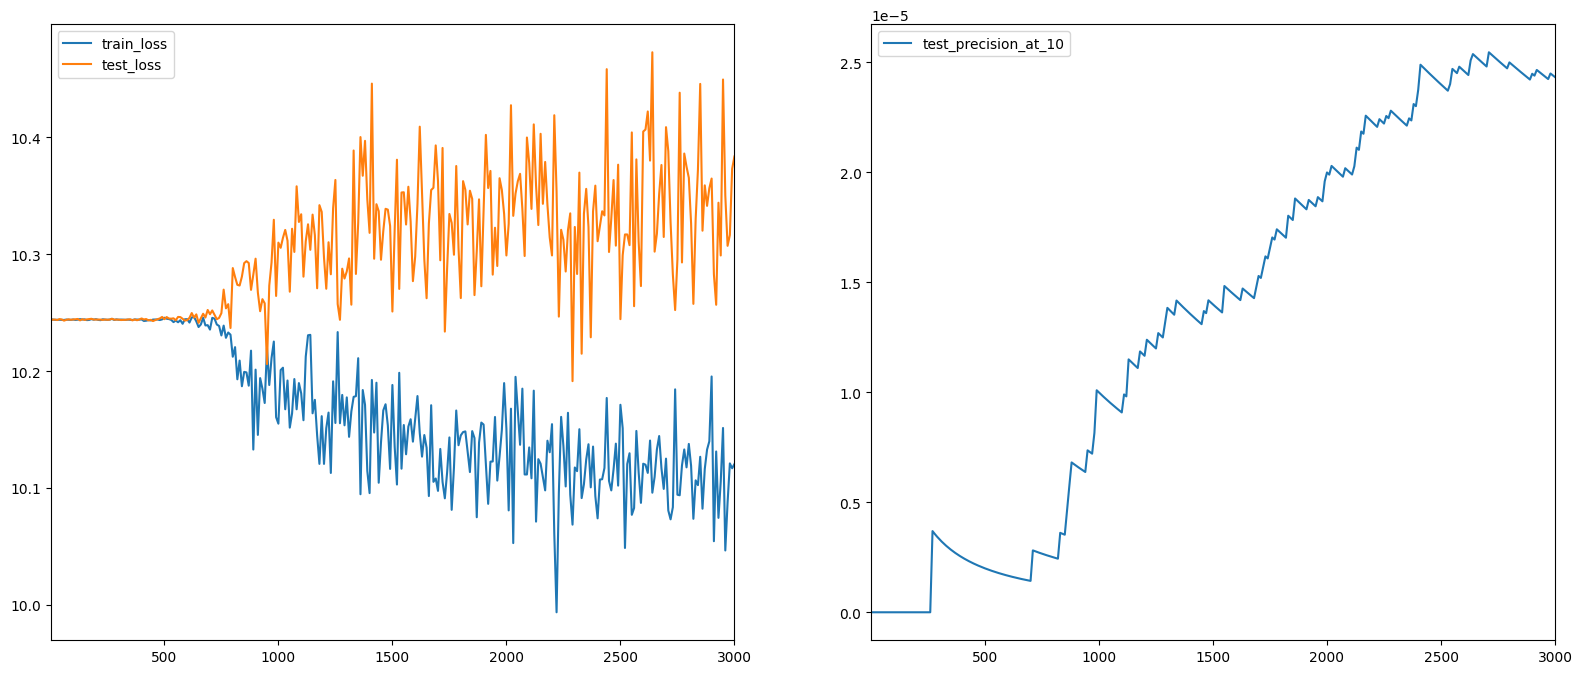

In [44]:
# Create feature embedding columns
def make_embedding_col(key, embedding_dim):
  categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
      key=key, vocabulary_list=list(set(novels[key].values)), num_oov_buckets=0)
  return tf.feature_column.embedding_column(
      categorical_column=categorical_col, dimension=embedding_dim,
      # default initializer: trancated normal with stddev=1/sqrt(dimension)
      combiner='mean')

with tf.Graph().as_default():
  softmax_model = build_softmax_model(
      rated_novels,
      embedding_cols=[
          make_embedding_col("novel_id", 35),
          make_embedding_col("genre", 3),
      ],
      hidden_dims=[35])

softmax_model.train(
    learning_rate=8., num_iterations=3000, optimizer=tf.train.AdagradOptimizer)

In [111]:
novel_neighbors(softmax_model, "SSS-Rank Mechanic Player", DOT, 100)

Nearest neighbors of : SSS-Rank Mechanic Player.
  novel_id  dot score                  titles            genres
8        9      0.411  Permanent Martial Arts  Fantasy-Xuanhuan


,novel_id,dot score,titles,genres
15113,15114,1.848,SSS-Rank Mechanic Player,Korean
15086,15087,1.653,Brother Dao Committed Evil Again,Action-Fantasy-Seinen-Xianxia
17432,17433,1.539,Zongwu: Well versed in ancient and modern time...,Fan-Fiction-Faloo
17641,17642,1.535,Pirate God Class Shipbuilder,Fan-Fiction-Faloo
6795,6796,1.534,The Cause and Effect of Liao Zhai,Action-Adventure-Fantasy-Martial Arts-Xianxia
...,...,...,...,...
23857,23858,1.376,The Rebirth of an Ill-Fated Consort,Drama-Historical-Josei-Romance
13602,13603,1.376,Da Qin Raising Country People,Fantasy-Urban
28100,28101,1.373,Debt Collection,Romance
27984,27985,1.373,Black & White,Drama-Romance
